# Decomposing Time Series

### Loading Libraries

In [2]:
%cd ../..

/Users/joaquinromero/Desktop


In [19]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Warnings
import warnings

# IO & Requests
import requests
from io import StringIO

# OS
import os
import sys
import pickleshare
import missingno as msno
from itertools import cycle

# PyArrow
import pyarrow as pa

# Path & Notebook Optimizer
from pathlib import Path
from tqdm.auto import tqdm

# Scikit-Learn
from sklearn.metrics import mean_absolute_error

# IPython
from IPython.display import display, HTML

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
tqdm.pandas()

np.random.seed()

pio.templates.default = "plotly_white"

sys.path.append('/Users/joaquinromero/Desktop/MTSF')

In [6]:
warnings.filterwarnings("ignore", category=UserWarning)

warnings.filterwarnings("ignore", category=FutureWarning)

warnings.filterwarnings("ignore", message="'force_all_finite' was renamed to 'ensure_all_finite'")

In [7]:
os.makedirs("imgs/chapter_03", exist_ok=True)

preprocessed = Path.home() / "Desktop" / "data" / "london_smart_meters" / "preprocessed"

In [8]:
assert preprocessed.is_dir(), "You have to run 02 - Preprocessing London Smart Meter Dataset.ipynb in Chapter02 before running this notebook"

In [16]:
from itertools import cycle

def format_plot(fig, legends=None, xlabel="Time", ylabel="Value", font_size=15, title_font_size=20):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
        
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title=dict(
            text=fig.layout.title.text if fig.layout.title.text else "",
            x=0.5,
            xanchor="center",
            yanchor="top",
            font=dict(size=title_font_size)
        ),
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.98,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title=dict(
                text=ylabel,
                font=dict(size=font_size)
            ),
            tickfont=dict(size=font_size)
        ),
        xaxis=dict(
            title=dict(
                text=xlabel,
                font=dict(size=font_size)
            ),
            tickfont=dict(size=font_size)
        )
    )
    
    return fig

### Generate Charts for Trend and Seasonality

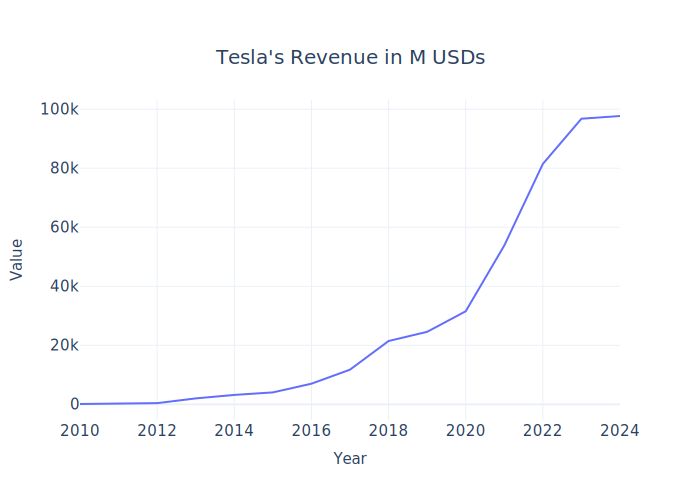

In [17]:
# Creating a session and disabling SSL verification (be cautious with this approach due to security concerns)
session = requests.Session()
#session.verify = False

url = "https://en.wikipedia.org/wiki/Tesla,_Inc."
r = session.get(url)  # Use the session object here for the request
website = r.text

# Wrap the HTML content in a StringIO object
tesla_revenue = pd.read_html(StringIO(website), encoding="UTF-8")[7][['Year', "Revenue (US$ m)"]]

tesla_revenue = tesla_revenue[tesla_revenue.Year>=2010]
fig = px.line(tesla_revenue, x="Year", y="Revenue (US$ m)", title="Tesla's Revenue in M USDs")
fig = format_plot(fig, xlabel="Year")
fig.write_image("imgs/chapter_03/tesla_revenue.png")
fig.show(renderer="svg")

In [ ]:
df = sm.datasets.sunspots.load_pandas().data
fig=px.line(df, x="YEAR", y="SUNACTIVITY", title="# of Sunspots Years 1749 - 2017")
fig = format_plot(fig, xlabel="Year")
fig.write_image("imgs/chapter_03/sunspots.png")
fig.show(renderer="svg")

In [18]:
df = pd.DataFrame({"x": np.arange(13)})

for i in range(1,4):
    df[f'Fourier Cosine Term {i}'] = np.cos((2 * np.pi * df.x * i) / 12)
    df[f'Fourier Sine Term {i}'] = np.sin((2 * np.pi * df.x * i) / 12)

df = pd.melt(df, id_vars="x",var_name="Fourier Terms")

In [ ]:
fig = px.line(df[df['Fourier Terms'].str.contains("Cosine")], x="x", y="value", line_dash="Fourier Terms", title="Fourier Terms")
fig = format_plot(fig, xlabel="x", ylabel="$cos(2\pi/P \cdot n \cdot x)$")
fig.write_image("imgs/chapter_03/fourier_terms.png")
fig.show(renderer="svg")

In [ ]:
fig = px.line(df[df['Fourier Terms'].str.contains("Term 1")], x="x", y="value", line_dash="Fourier Terms", title="Sine and Cosine Fourier Terms")
fig = format_plot(fig, xlabel="x", ylabel="value")
fig.write_image("imgs/chapter_03/sine_cos_terms.png")
fig.show(renderer="svg")

### Reading Blocks 0-7

In [ ]:
from src.utils.data_utils import compact_to_expanded

In [ ]:
try:
    block_df = pd.read_parquet(preprocessed/"london_smart_meters_merged_block_0-7.parquet")
    display(block_df.head())
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 02 - Preprocessing London Smart Meter Dataset.ipynb in Chapter02
    </div>
    """))

In [ ]:
#Converting to expanded form
exp_block_df = compact_to_expanded(block_df[block_df.file=="block_7"], timeseries_col = 'energy_consumption',
static_cols = ["frequency", "series_length", "stdorToU", "Acorn", "Acorn_grouped", "file"],
time_varying_cols = ['holidays', 'visibility', 'windBearing', 'temperature', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon',
       'humidity', 'summary'],
ts_identifier = "LCLid")

exp_block_df.head()

In [ ]:
# Taking a single time series from the block
ts_df = exp_block_df[exp_block_df.LCLid=="MAC000193"].set_index("timestamp")

#### Filling in Missing Values

In [ ]:
from src.imputation.interpolation import SeasonalInterpolation

ts = SeasonalInterpolation(seasonal_period=48*7).fit_transform(ts_df.energy_consumption.values.reshape(-1,1)).squeeze()

### Seasonal Decomposition

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
from src.decomposition.seasonal import STL, FourierDecomposition, MultiSeasonalDecomposition

In [ ]:
def decomposition_plot(
        ts_index, observed=None, seasonal=None, trend=None, resid=None
    ):
        """Plots the decomposition output
        """
        series = []
        if observed is not None:
            series += ["Original"]
        if trend is not None:
            series += ["Trend"]
        if seasonal is not None:
            series += ["Seasonal"]
        if resid is not None:
            series += ["Residual"]
        if len(series) == 0:
            raise ValueError(
                "All component flags were off. Need atleast one of the flags turned on to plot."
            )
        fig = make_subplots(
            rows=len(series), cols=1, shared_xaxes=True, subplot_titles=series
        )
        x = ts_index
        row = 1
        if observed is not None:
            fig.append_trace(
                go.Scatter(x=x, y=observed, name="Original"), row=row, col=1
            )
            row += 1
        if trend is not None:
            fig.append_trace(
                go.Scatter(x=x, y=trend, name="Trend"), row=row, col=1
            )
            row += 1
        if seasonal is not None:
            fig.append_trace(
                go.Scatter(x=x, y=seasonal, name="Seasonal"),
                row=row,
                col=1,
            )
            row += 1
        if resid is not None:
            fig.append_trace(
                go.Scatter(x=x, y=resid, name="Residual"), row=row, col=1
            )
            row += 1

        fig.update_layout(
            title_text="Seasonal Decomposition",
            autosize=False,
            width=1200,
            height=700,
            title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
            titlefont={"size": 20},
            legend_title=None,
            showlegend=False,
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
        return fig

### Moving Averages

In [ ]:
#Does not support misssing values, so using imputed ts instead
res = seasonal_decompose(ts, period=7*48, model="additive", extrapolate_trend="freq", filt=np.repeat(1/(30*48), 30*48))

In [ ]:
fig = decomposition_plot(ts_df.index, res.observed, res.seasonal, res.trend, res.resid)
fig.write_image("imgs/chapter_03/moving_avg_decomposition.png")
fig.show(renderer="svg")

In [ ]:
#Let's zoom in on a few days to better see the seasonality extracted
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-4"])
fig.write_image("imgs/chapter_03/moving_avg_decomposition_zoomed.png")
fig.show(renderer="svg")

### Seasonality and Trend Decomposition using Loess (STL)

In [ ]:
#Supports missing values and expects a series or dataframe with datetime index
stl = STL(seasonality_period=7*48, model = "additive")
res_new = stl.fit(ts_df.energy_consumption)

In [ ]:
fig = res_new.plot(interactive=True)
fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
fig.write_image("imgs/chapter_03/stl_decomposition.png")
fig.show(renderer="svg")

In [ ]:
#Let's zoom in on a few days to better see the seasonality extracted
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-4"])
fig.write_image("imgs/chapter_03/stl_decomposition_zoomed.png")
fig.show(renderer="svg")

### Seasonality and Trend Decomposition using Loess and Fourier Terms (Fourier Decomposition)

In [ ]:
#Doesn't support missing values, and expects a series or datafeame with datetime index
stl = FourierDecomposition(seasonality_period="hour", model = "additive", n_fourier_terms=5)
res_new = stl.fit(pd.Series(ts.squeeze(), index=ts_df.index))

In [ ]:
fig = res_new.plot(interactive=True)
fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
fig.write_image("imgs/chapter_03/fourier_decomposition_hourly.png")
fig.show(renderer="svg")

In [ ]:
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-4"])
fig.write_image("imgs/chapter_03/fourier_decomposition_hourly_zoomed.png")
fig.show(renderer="svg")

#### Custom Seasonality

In [ ]:
#Making a custom seasonality term
ts_df["dayofweek"] = ts_df.index.dayofweek
ts_df["hour"] = ts_df.index.hour

#Creating a sorted unique combination df
map_df = ts_df[["dayofweek","hour"]].drop_duplicates().sort_values(["dayofweek", "hour"])

# Assigning an ordinal variable to capture the order
map_df["map"] = np.arange(1, len(map_df)+1)

# mapping the oprdinal mapping back to the original df and getting the seasonality array
seasonality = ts_df.merge(map_df, on=["dayofweek","hour"], how='left', validate="many_to_one")['map']

In [ ]:
stl = FourierDecomposition(model = "additive", n_fourier_terms=50)
res_new = stl.fit(pd.Series(ts, index=ts_df.index), seasonality=seasonality)

In [ ]:
fig = res_new.plot(interactive=True)
fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
fig.write_image("imgs/chapter_03/fourier_decomposition.png")
fig.show(renderer="svg")

In [ ]:
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-4"])
fig.write_image("imgs/chapter_03/fourier_decomposition_zoomed.png")
fig.show(renderer="svg")

In [ ]:
### Multiple Seasonality Decomposition using Loess (MSTL)

#### Using Averages as the seasonal model

In [ ]:
stl = MultiSeasonalDecomposition(seasonal_model="averages",seasonality_periods=[48*365, 48*7, 48], model = "additive")
res_new = stl.fit(pd.Series(ts, index=ts_df.index))

In [ ]:
fig = res_new.plot(interactive=True)

fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
fig.write_image("imgs/chapter_03/mstl_decomposition_averages.png")
fig.show(renderer="svg")

In [ ]:
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-4"])

fig.write_image("imgs/chapter_03/mstl_decomposition_averages_zoomed.png")
fig.show(renderer="svg")

#### Using Fourier Decomposition as Seasonal Model

In [ ]:
stl = MultiSeasonalDecomposition(seasonal_model="fourier",seasonality_periods=["day_of_year", "day_of_week", "hour"],
                                 model = "additive",
                                 n_fourier_terms=10)

res_new = stl.fit(pd.Series(ts, index=ts_df.index))

In [ ]:
fig = res_new.plot(interactive=True)
fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
fig.write_image("imgs/chapter_03/mstl_decomposition_fourier.png")
fig.show(renderer="svg")

In [ ]:
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-4"])
fig.write_image("imgs/chapter_03/mstl_decomposition_fourier_zoomed.png")
fig.show(renderer="svg")

### MSTL decomposition in STATSMODELS

In [ ]:
exp_block_df.head()

In [ ]:
ts_df_mstl = exp_block_df[exp_block_df.LCLid=="MAC000050"][['timestamp','energy_consumption']].set_index('timestamp')
ts_df_mstl.head()

In [ ]:
stl_kwargs = {"seasonal_deg": 0, }
mstl = MSTL(ts_df_mstl['energy_consumption'], 
            periods=[48, 48*7], 
            #windows=[101, 101],  # Setting this large along with `seasonal_deg=0` will force the seasonality to be periodic.
            #stl_kwargs = stl_kwargs,
            )
res = mstl.fit()

In [ ]:
res.trend.head()

In [ ]:
res.seasonal.head()

In [ ]:
res.resid.head()

In [ ]:
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

# Creating a plot
fig = res.plot()

for ax in fig.axes:
    ax.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-02-01'))

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()